[View in Colaboratory](https://colab.research.google.com/github/Jmaihuire/training/blob/master/230_T_HW1.ipynb)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

from datetime import datetime
import requests
import time
from pandas.tseries.offsets import BDay

import urllib2
import csv
from bs4 import BeautifulSoup

##1) Get historical information for a Portfolio:

###1.1) Scrape  and choose stocks:

####1.1.1) Creating data source

This code gets prices (OHLC) and volume for stocks and indexes from Yahoo Finance using web scrapping.

  * connect2Webside: Gets the relevant url then yields a data frame table with OHLC prices and volume for a set of 100 days
  * getStockData: Stacks all tables in a list then return the list of  the 'businessDays'  previous to 'endPeriod'.

In [0]:
def getStockData(Tickers_list,endPeriod,businessDays,flag_index=False):
  Data_list=[]
  for tick in Tickers_list:
    baseUrl='https://finance.yahoo.com/quote/'
    businessDaysSets = int(businessDays/100)
    temp=[]
    for y in range(businessDaysSets):
        end = endPeriod - BDay(y*100+(y))
        start = end - BDay(100)
        unixStart = int(time.mktime(start.timetuple()))
        unixEnd = int(time.mktime(end.timetuple()))
        if flag_index==False:
          url_link =(baseUrl + str(tick) + '/history?period1=' + str(unixStart) + '&period2=' + str(unixEnd) + '&interval=1d&filter=history&frequency=1d')
        else:
          url_link =(baseUrl+'%5E' + str(tick) + '/history?period1=' + str(unixStart) + '&period2=' + str(unixEnd) + '&interval=1d&filter=history&frequency=1d')
        temp.append(connect2Website(url_link))
#     print('{}/n:{}/n'.format(tick,temp[-1].head(3)))
    #From list to DataFrame
    dff=temp[0]
    for i in range(1,len(temp)):
        dff=pd.concat([dff,temp[i]],axis=0)
    Data_list.append(dff)
  return Data_list
    
    
        
def connect2Website(url):
    columns_show=['Date','Open','High','Low','Close','Adjust','Volume']
    req = urllib2.Request(url, headers={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8'})
    page = urllib2.urlopen(req).read()
    soup = BeautifulSoup(page, "html5lib")
    snap = soup.find("table", class_="W(100%) M(0)") #Find table where our data lies
    snap_header = snap.find('thead') #thead is the head of our table
    headers = snap_header.find_all('th')
    snap_body = snap.find('tbody')  #All the frame where are our rows
    rows = snap_body.find_all('tr') #All the rows in our table
    ###
    Dat=[]
    for row in rows:
        line = row.get_text().strip().split()
        date_tag = row.find_all("td", class_="Py(10px) Ta(start) Pend(10px)")
        if date_tag:
            values_tag = row.find_all("td", class_="Py(10px) Pstart(10px)")
            line = [date_tag[0].get_text().strip().replace(",", "")] + [v.get_text().strip().replace(",", "") for v in values_tag]
            Dat.append(line)
    #Setting Dates as index and astype(float)
    temp=pd.DataFrame(Dat,columns=columns_show)
    temp['Date']=temp['Date'].apply(lambda x: datetime.strptime(x,'%b %d %Y'))
    temp.set_index(['Date'],inplace=True)
#     print('{}/n:{}/n'.format(url,temp.head(3)))
    return pd.DataFrame(temp.astype(float),columns=columns_show[1:])

####1.1.2) Selecting 10 tech companies:
The strategy is to create a long-short portfolio  for similar companies using the extended idea of "Pairs-Trading". 

  * Select a group of companies that have similar fundamentals (same sector, etc)
  * Calculate a cointegration vector then short relative expensive then buy the relative cheap (Not doing in this assignment)

In [0]:
Tickers=['NFLX','AMZN','GOOG','TSLA','FB','BABA','SNAP','AAPL','PYPL','NVDA']
end = datetime.today() 
Data_df=getStockData(Tickers,end,365,flag_index=False)

###1.2) Cleaning Data:
  * I already change from unicode to float 
  * Drop any 'NA' value
  * Create a list for all stocks resampled  by D, W and M (My original dataframe  has as an index  the dates, but they start from the most recent. Doing resample, it sorts it automaticaly

In [0]:
#Datframe
Data_df_d=[]
Data_df_w=[]
Data_df_m=[]
for i in Data_df:
  Data_df_d.append(i.resample('D').last())
  Data_df_w.append(i.resample('W').last())
  Data_df_m.append(i.resample('M').last())

#Prices:
Data_p_agg_d=pd.concat(Data_df_d,keys=Tickers,names=['Stocks']).dropna()
Data_p_agg_w=pd.concat(Data_df_w,keys=Tickers,names=['Stocks']).dropna()
Data_p_agg_m=pd.concat(Data_df_m,keys=Tickers,names=['Stocks']).dropna()

###1.3) Basic statistics for each stock:
  * Prices:
    * Count: Almost 293 dates of data in all stocks
    * Mean: This measure is not relevant when dealing with prices (scale issue), but the highest average daily prices is  for Amazon.
    * Std: The most volatile stock price is Amazon (scale issue)
  * Volume:
    * Mean: Apple  has the highest volume in average follow by Snapchat
    * Std: The most volatile stock volume are Snapchat, Facebook and Apple

In [150]:
Data_p_agg_d.groupby('Stocks').describe().round(1).style

###1.4) Making plots:
  * According to graphics the best performer is Netflix and the worst one is Snatchat. One naive approach might be long(best performing stock)-short(worst performing stock) portfolio
  * The normalized prices (cumulative return starting at 1) in 1.4.1 and 1.4.3 show that there are some deviation from prices that have the same trend. For instance, Tesla vs Google and Paypal vs Facebook.
  In general these companies might have some commonality , so there are some trading oportunities using a cointegration vector (both weekly and monthly)
  * Returns (1.4.2) are in general stationaries around 0, so there are not to much information for forecasting return using past returns
  * Finally, I assume that stock growth is just the variation of monthly prices  in 1.4.4

####1.4.1) Plotting prices weekly and monthly

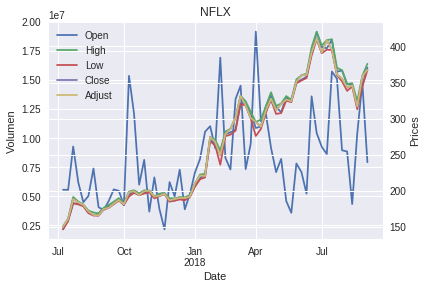

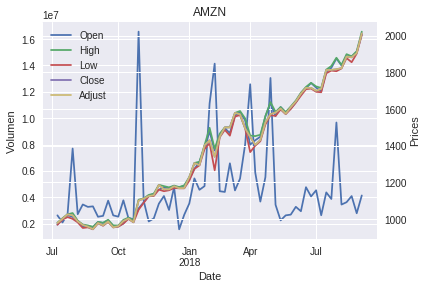

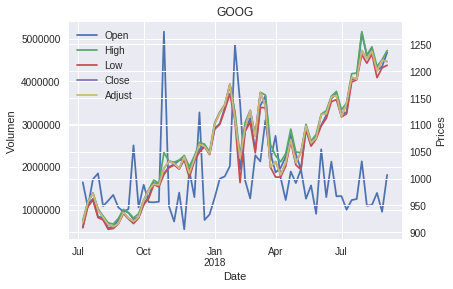

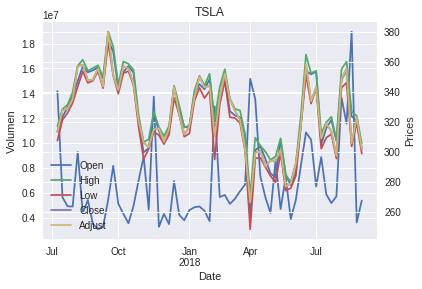

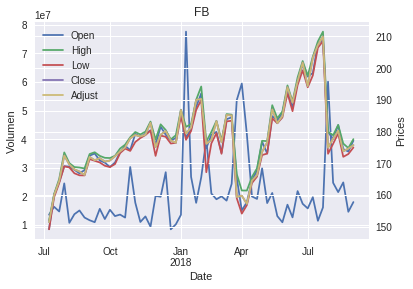

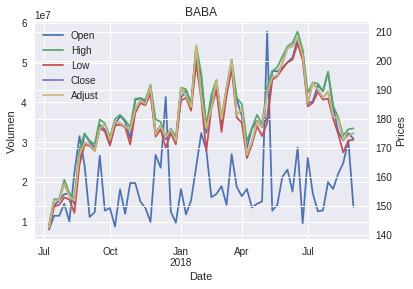

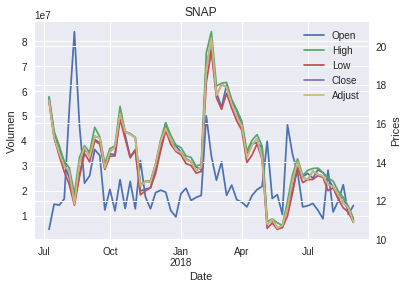

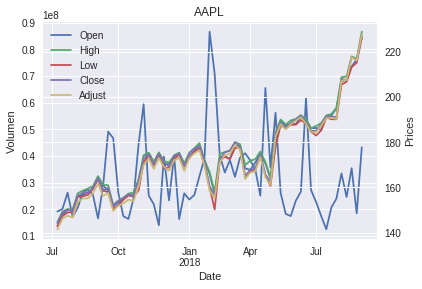

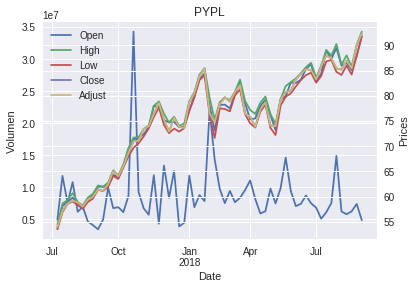

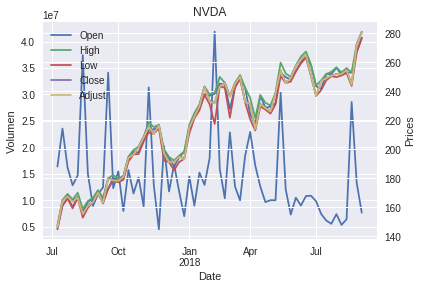

In [151]:
#Weekly
for i in Tickers:
  fig0, ax0 = plt.subplots()
  ax1 = ax0.twinx()
  Data_p_agg_w.iloc[:,:-1].xs(i).plot(ax=ax1)
  Data_p_agg_w.iloc[:,-1].xs(i).plot(ax=ax0)
  ax1.set_ylabel('Prices')
  ax0.set_ylabel('Volumen')
  ax1.set_title(i)
  plt.show()

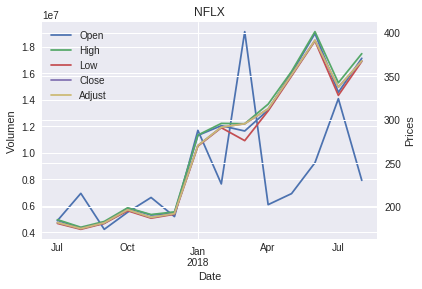

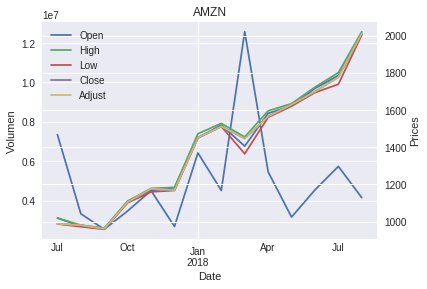

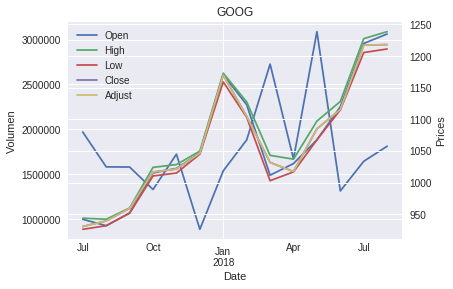

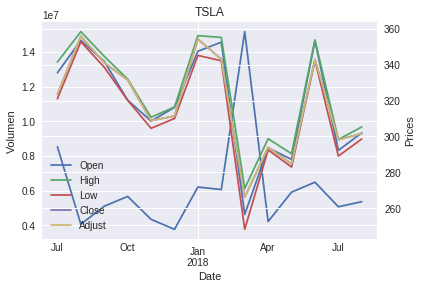

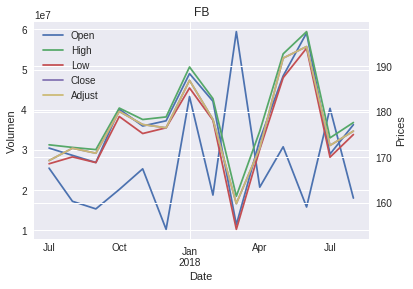

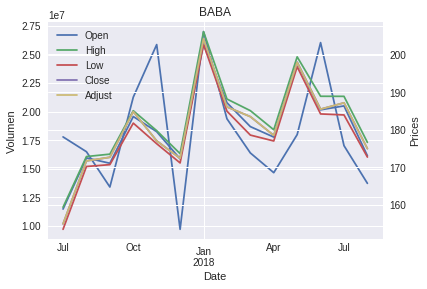

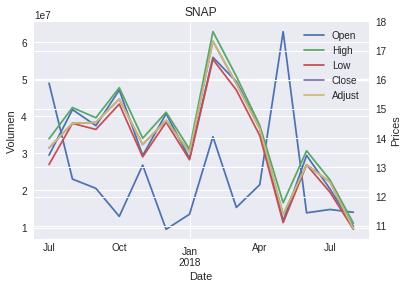

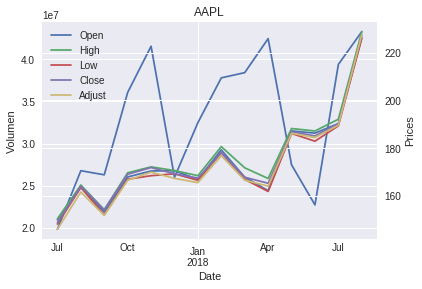

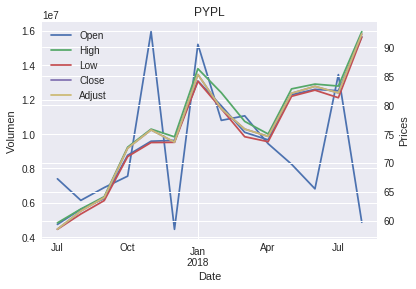

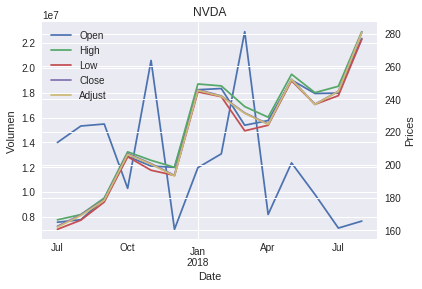

In [152]:
#Monthly data:
for i in Tickers:
  fig0, ax0 = plt.subplots()
  ax1 = ax0.twinx()
  Data_p_agg_m.iloc[:,:-1].xs(i).plot(ax=ax1)
  Data_p_agg_m.iloc[:,-1].xs(i).plot(ax=ax0)
  ax1.set_ylabel('Prices')
  ax0.set_ylabel('Volumen')
  ax1.set_title(i)
  plt.show()

#### Using weekly data, there are some companies that might cointegrate, for instance Tesla vs Google and Paypal vs Facebook


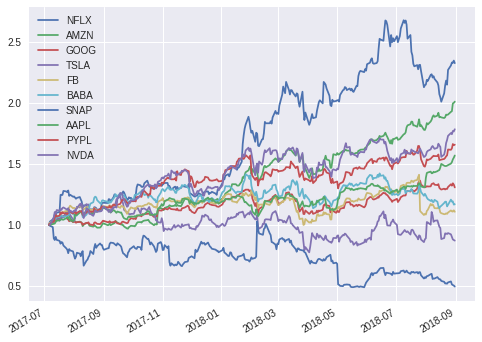

In [153]:
#Weekly data:
  plt.figure(figsize=(8,6))
  for i in Tickers:
    temp=Data_p_agg_d['Adjust'].xs(i)
    temp2add=pd.Series(temp.iloc[0])
    temp=pd.concat([temp2add,temp])
    (1+np.log(temp/temp.shift(1))).dropna().cumprod().plot()
  plt.legend(Tickers);

####1.4.2) Weekly return per stock

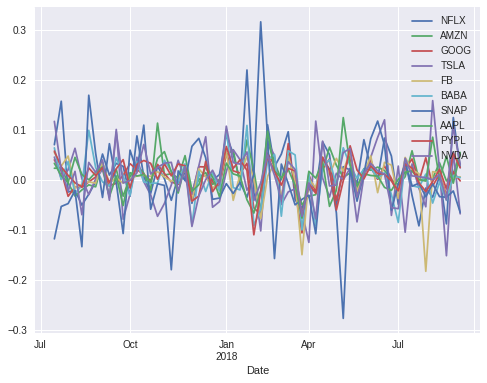

In [154]:
plt.figure(figsize=(8,6))
for i in Tickers:
  np.log(Data_p_agg_w.xs(i)/Data_p_agg_w.xs(i).shift(1)).dropna()['Adjust'].plot()
plt.legend(Tickers);

####1.4.3) Monthly cummulative return by stock

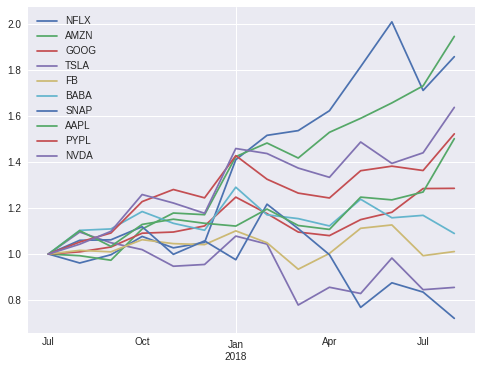

In [155]:
#Monthly data:
  plt.figure(figsize=(8,6))
  for i in Tickers:
    temp=Data_p_agg_m['Adjust'].xs(i)
    temp2add=pd.Series(temp.iloc[0])
    temp=pd.concat([temp2add,temp])
    (1+np.log(temp/temp.shift(1))).dropna().cumprod().plot()
  plt.legend(Tickers);

####1.4.4) Monthly growth of a stock per stock 

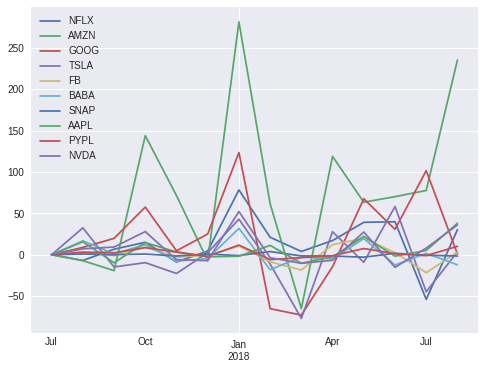

In [156]:
plt.figure(figsize=(8,6))
for i in Tickers:
  temp=Data_p_agg_m['Adjust'].xs(i)
  temp2add=pd.Series(temp.iloc[0])
  temp=pd.concat([temp2add,temp])
  (temp-temp.shift(1)).dropna().plot()
plt.legend(Tickers);

###1.5) Processing data for all stocks and SVD (Using daily data)
I would like to know if it is possible represent all the stocks returns with one time series (dimensionality reduction). This is the evigenvector linked to the highest singular value
  * In 1.5.1 the first eigenvector capture very well the variability of all this sector. In particular, look similar to the cumulative return of Facebook
  * One trading idea might be do a pairs trading between Facebook and this 1st  SVD component

In [0]:
All_adj_prices=[]
for i in Tickers:
  All_adj_prices.append(Data_p_agg_d['Adjust'].xs(i))
#   All_index.append(Data_p_agg_d['Adjust'].xs(i).shape[0])
Data_p_agg_d_stock=pd.concat(All_adj_prices, axis=1, keys=[s.name for s in All_adj_prices])
Data_p_agg_d_stock.dropna(inplace=True)
Data_p_agg_d_stock.columns=Tickers

####1.5.1) Getting the eigenvector from SVD

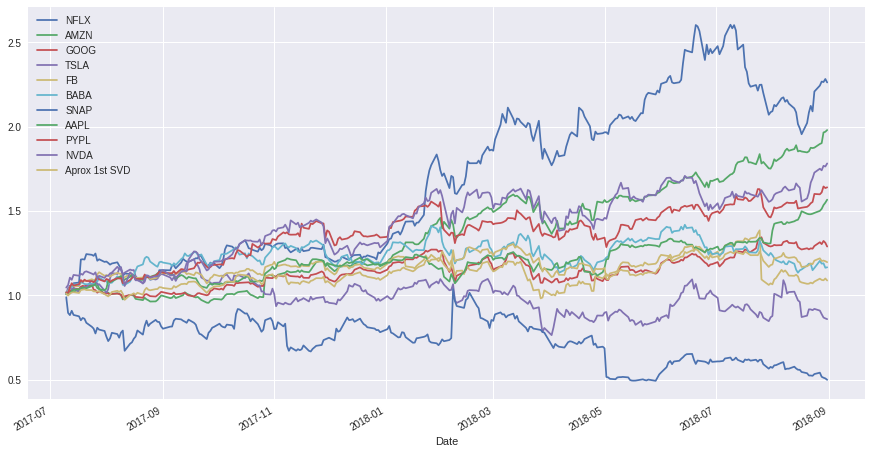

In [158]:
data=np.log(Data_p_agg_d_stock/Data_p_agg_d_stock.shift(1)).dropna()
u, s, vt = np.linalg.svd(data, full_matrices=True)
k=1 #Just the first eigenvector
data['Aprox 1st SVD']=u[:,:k].dot(np.diag(s[:k]**0.5))*vt[:k,:k]
(1+data).cumprod().plot(figsize=(15,8));

##2) Get historical information for S&P 500:
  * For getting data for indexes from Yahoo Finance using web Scrapping, we chance the base url (customized) in 2.1
  * Daily returns for S&P500 is stationary around 0 in 2.3
  * Making a comparizon of cumulative returns between S&P500 and Netflix, the later shows 120% meanwhile the former 20%

###2.1) Get data of a index from Yahoo Finance

In [0]:
Tickers_index=['GSPC']
end = datetime.today() 
Data_df_index=getStockData(Tickers_index,end,350,flag_index=True)#get a list
Data_df_index_df=Data_df_index[0].resample('D').last().dropna() #Right index from the oldest to the newest

###2.2) Basis statistics

In [160]:
Data_df_index_df.describe().round(1)

,Open,High,Low,Close,Adjust,Volume
count,293.0,293.0,293.0,293.0,293.0,2.930000e+02
mean,2657.4,2667.7,2646.6,2657.7,2657.7,3.390393e+09
std,128.4,130.1,127.5,128.6,128.6,5.692710e+08
min,2413.5,2424.3,2407.7,2409.8,2409.8,1.349780e+09
25%,2557.2,2562.4,2552.1,2559.4,2559.4,3.050040e+09
50%,2678.1,2685.3,2659.0,2671.9,2671.9,3.349370e+09
75%,2753.2,2765.0,2744.4,2752.0,2752.0,3.639430e+09
max,2908.9,2916.5,2898.4,2914.0,2914.0,5.891660e+09


###2.3) Plot daily returns:

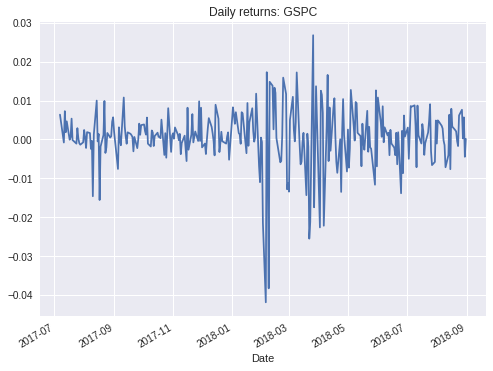

In [161]:
np.log(Data_df_index_df/Data_df_index_df.shift(1))['Adjust'].plot(figsize=(8,6));
plt.title('Daily returns: {}'.format(Tickers_index[0]));

###2.4) Best performing stock and S&P 500:

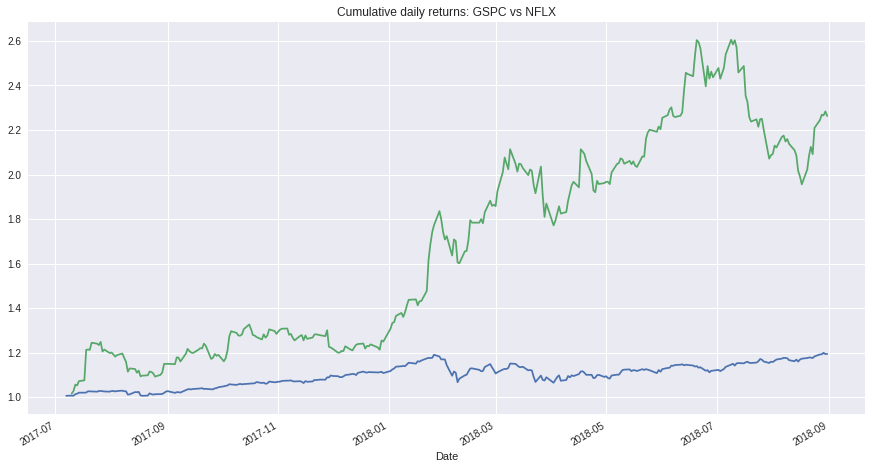

In [162]:
##
data_stocks=np.log(Data_p_agg_d_stock/Data_p_agg_d_stock.shift(1)).dropna()
data_index=np.log(Data_df_index_df/Data_df_index_df.shift(1))['Adjust'].dropna()
##
(1+data_index).cumprod().plot(figsize=(15,8));
(1+data_stocks)[Tickers[0]].cumprod().plot(figsize=(15,8));
plt.title('Cumulative daily returns: {} vs {}'.format(Tickers_index[0],Tickers[0]));